# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 6 декабря 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 6 декабря, -4 балла после 06:00 13 декабря, -6 баллов после 06:00 20 декабря

При отправлении ДЗ указывайте фамилию в названии файла

Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush Необходимо в slack создать таск в приватный чат:
/todo Фамилия Имя ссылка на гитхаб @alkhamush
Пример:
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [2]:
USER_NAME = u"Кузнецова".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print "Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
)

Имплементируйте обучение логистической регрессии с L2 регуляризацией с помощью метода Mini Batch Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту, т.е. в алгоритме надо
    * Перемешать выборку
    * Посчтитать градиент на одном объекте
    * Сделать шаг спуска
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Почитать градиент по мини батчам
    * Сделать шаг спуска
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в обучающей выборке (тем или иным способом)

# Реализация модели

## Имплементация (6 баллов)

In [100]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C=1, alpha=0.01, max_epoch=10):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        
    def sigmoid(self, x):
        return 1.0 / (1 + np.exp(-x))
    
    def fit(self, X, y=None):
        '''
        Обучение модели
        '''
        X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
        X = np.c_[np.ones(X.shape[0]), X]
        self.weights = np.empty(shape=(X.shape[1],))
        self.loss_list = []
        for epoch in range(self.max_epoch):
            
            #shuffle
            batch_size = np.sqrt(X.shape[0]).astype(int)
            batch_starts = np.arange(0, X.shape[0] , batch_size)
            
            for index in batch_starts:
                batch_loss_list = []
                X_batch = X[index:index + batch_size]
                y_batch = y[index:index + batch_size]
            
                y_hat = self.sigmoid(X_batch.dot(self.weights))
                error = y_hat - y_batch
                loss = np.sum(error ** 2)
                gradient = X_batch.T.dot(error) / X_batch.shape[0]
                #add regularization
                self.weights = self.weights - self.alpha * gradient
                batch_loss_list.append(loss)
                
            self.loss_list.append(np.mean(batch_loss_list))
    
    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
    
        return self
        
    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
        X = np.c_[np.ones(X.shape[0]), X]
        
        return labels
        return y_hat
    
    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''

        
        return y_hat_proba

## Проверка на синтетических данных (2 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

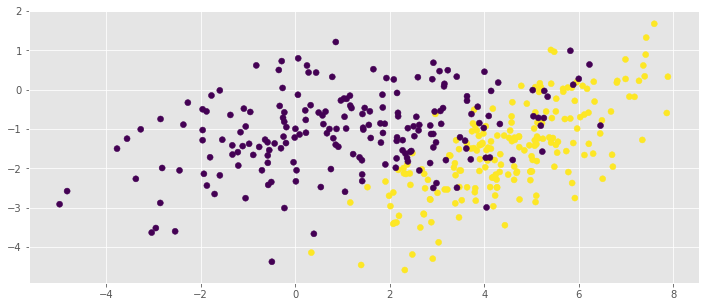

In [14]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

plt.scatter(X[:,0], X[:,1], c=y)

In [113]:
model = MySGDClassifier(max_epoch=20)
model.fit(X, y)

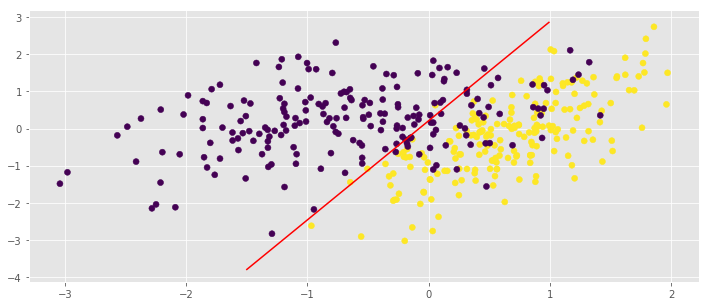

In [116]:
x_axis = np.arange(-1.5,1,.01)
plt.scatter(X[:, 0], X[:, 1], marker="o", c=y)
y_line = (-model.weights[0] - (model.weights[1] * x_axis)) / model.weights[2]
plt.plot(x_axis, y_line, "r-")

In [98]:
model.loss_list

[7.8470601098133779,
 7.4146819511119055,
 7.0064207316546057,
 6.6236968427256349,
 6.2671086956569217,
 5.9365605430988699,
 5.6314068716709587,
 5.3505955525283797,
 5.0927977109952032,
 4.8565177792143812]

In [75]:
batch_starts = np.arange(0, X.shape[0] , batch_size)
for index in batch_starts:
    print X[index:index + batch_size]


[[ 0.88433099 -1.28313775]
 [ 1.95887404  0.65180224]
 [ 0.08024322 -2.37433214]
 [ 0.56238043 -1.08975834]
 [ 0.89042617  0.10040807]
 [ 1.49967907  0.6872249 ]
 [ 0.72176498 -0.74928402]
 [ 0.84552113 -0.35937545]
 [ 0.53097367 -1.53022632]
 [ 0.15215169 -1.13818088]
 [ 1.03229092  2.08452428]
 [ 0.21749207 -1.46196969]
 [-0.19826026 -3.02221104]
 [ 0.54146637 -0.44982329]
 [ 1.5084852  -0.32491527]
 [ 0.87149143 -0.11371499]
 [-0.50556807 -1.08354329]
 [ 0.74200616  0.09336679]]
[[ 1.35263431 -0.29875089]
 [ 0.47426487 -0.21553762]
 [-0.17820951 -0.55189023]
 [ 1.78951566  2.41641773]
 [ 0.39500724 -0.2254451 ]
 [ 1.10460197  1.21778012]
 [ 0.52654762  0.75422267]
 [ 0.87659346  0.6666963 ]
 [-0.03846634 -0.77173091]
 [ 0.90077816  0.05818559]
 [ 0.82730648 -0.10432815]
 [ 0.43898351 -0.07807783]
 [ 0.44084453 -0.04762753]
 [-0.35699374 -0.95100731]
 [ 0.41619376 -0.70495984]
 [ 0.92088882  1.26397529]
 [ 0.68105981  0.42860945]
 [ 0.72603102 -0.72035991]]
[[-0.07010227 -2.02757532]

In [69]:
weights = np.empty(shape=(X.shape[1],))
weights

array([ 0.62670648,  0.72754361])

## Анализ сходимости (2 балл)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

In [ ]:
## Your Code Here

# Введение в конкурсную задачу

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

### Правила
* Объединяться в команды по правилам конкурса можно, но по правилам нашего курса - нельзя)
* Вы можете использовать любой алгоритм, даже неизученный в нашем курсе (если на защите сможете объяснить как он работает)
* Имейте ввиду, что вы должны отправить результаты строго до 14 мая 23:59 GMT на сайт соревнования (раздел submission). Без результата в leaderboard оценка выставлена не будет.

## Данные

Для того, чтобы получить данные необходимо зарегистрироваться на сайте соревнования. 

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


Данные поставляются в двух форматах:
* В формате json содержится полная информация по текущему состоянию раунда
* В табличном формате упрощенная аггрерированная информация по текущему состоянию раунда

В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если данные не будут помещаться вам с оперативную память, рекомендуется совершить предобработку в python, а  моделирование выполнять с помощью [vowpal wabbit](https://github.com/JohnLangford/vowpal_wabbit).

In [ ]:
# Загрузка данных целиком
# df_list = []
# for chunk in range(1,5):
#     filepath = './trainingData_tabular_chunk%d.csv' % chunk
#     df_list.append(pd.read_csv(filepath, sep=','))

# df_data = pd.concat(df_list)

# Загрузка одной части данных
filepath = './trainingData_tabular_chunk1.csv'
df_data = pd.read_csv(filepath, sep=',')

In [ ]:
df_data.shape

In [ ]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [ ]:
df_data.head().T

In [ ]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощьб one-hot кодирования, добавьте к датасету и удалите прежние столбцы

In [ ]:
## Youd Code Here

## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Обучите модуль из первой части этого ДЗ на данных

In [ ]:
## Youd Code Here

## Применение модели (3 балла)
#### Задание
* Загрузите тестовые данные
* Выполните те же операции с датасетом, что и с обучающей выборкой
* Примените модель и загрузите решение на страницу конкурса
* Напечатайте ваш ник и оценку качества, полученную после загрузки

Судя по описанию, submission file должен состоять из одного столбца с числами, соответствующим вероятностям победы игрока.

In [ ]:
## Youd Code Here